# CNN from File

본 문서는 TensorFlow Keras 를 사용하여 CNN 을 구현해 보는 문서입니다.<br>
Keras 에서 제공하는 것이 아닌 직접 구하거나 만든 자료를 데이터셋으로 사용할 수 있도록 파일을 가져오는 방법을 연습해 봅니다.<BR>

## 라이브러리 및 함수 설정

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import numpy as np

import matplotlib.pyplot as plt
def hist_view(hist):
  print('## training loss and acc ##')
  fig, loss_ax = plt.subplots()
  acc_ax = loss_ax.twinx()

  loss_ax.plot(hist.history['loss'], 'y', label='train loss')
  loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

  loss_ax.set_xlabel('epoch')
  loss_ax.set_ylabel('loss')
  loss_ax.legend(loc='center')

  acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
  acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
  acc_ax.set_ylabel('accuracy')
  acc_ax.legend(loc='center right')

  plt.show()

## Data File 다운로드
파일에 끌어다가 올리거나 구글 드라이브를 마운트 하는 방법으로 대체 가능합니다.

In [2]:
![ ! -f  iris0.csv ]&&wget https://github.com/Finfra/AI_Vision/raw/master/data/MNIST_Simple.tar
!tar -xvf MNIST_Simple.tar

--2021-08-09 11:28:11--  https://github.com/Finfra/AI_Vision/raw/master/data/MNIST_Simple.tar
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Finfra/AI_Vision/master/data/MNIST_Simple.tar [following]
--2021-08-09 11:28:11--  https://raw.githubusercontent.com/Finfra/AI_Vision/master/data/MNIST_Simple.tar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6228992 (5.9M) [application/octet-stream]
Saving to: ‘MNIST_Simple.tar’

MNIST_Simple.tar    100%[===================>]   5.94M  --.-KB/s    in 0.09s   

2021-08-09 11:28:11 (63.5 MB/s) - ‘MNIST_Simple.tar’ saved [6228992/6228992]

MNIST_Simple/
MNI

## File 에서 불러오기 위한 세팅

In [3]:
from os import listdir
from os.path import isfile, join
from pylab import *
from numpy import *

def getFolder(thePath,isFile=True):
    return [f for f in listdir(thePath) if isFile == isfile(join(thePath, f)) ]


def getImagesAndLabels(tPath,isGray=True):
    labels=getFolder(tPath,False)
    tImgDic={f:getFolder(join(tPath,f)) for f in labels}
    tImages,tLabels=None,None
    ks=sorted(list(tImgDic.keys()))
    oh=np.identity(len(ks))
    for label in tImgDic.keys():
        for image in tImgDic[label]:
            le=np.array([float(label)],ndmin=1)
            img_color=imread(join(tPath,label,image))
            if isGray:
                img=img_color[:,:,1]
            img1d=img.reshape([1,-1])
            if tImages is None:
                tImages, tLabels =img1d, le
            else:
                tImages,tLabels = np.concatenate((tImages,img1d),axis=0), np.append(tLabels,le ,axis=0)
    return (tImages,tLabels)

## File 불러오기

In [4]:
tPath='MNIST_Simple/train/'
train_images,train_labels=getImagesAndLabels(tPath)    
tPath='MNIST_Simple/test/'
test_images,test_labels=getImagesAndLabels(tPath)    


데이터 형태 가공

In [5]:

train_images = train_images.reshape((-1, 28, 28, 1))
test_images = test_images.reshape((-1, 28, 28, 1))
train_images, test_images = train_images / 255.0, test_images / 255.0

print("Shape of Train_images = {}".format(train_images.shape))

Shape of Train_images = (3000, 28, 28, 1)


file 확인

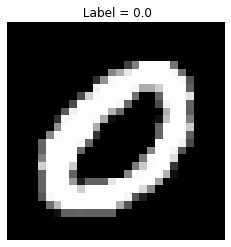

In [6]:
import matplotlib.pyplot as plt
plt.gray()
plt.axis("off") 
plt.title(" Label = "+str(train_labels[1000]) ) 
plt.imshow(train_images[1000].reshape(28, 28))

# i0=train_images[0]
# print(np.max(i0),np.min(i0),i0.shape,train_labels.shape,train_labels[0])

## CNN 모델 만들기

In [7]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

## 모델 훈련

In [8]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

hist = model.fit(train_images, train_labels,
          batch_size=128,
          epochs=10,
          validation_data=(test_images, test_labels))

Epoch 1/10
24/24 [==============================] - 4s 120ms/step - loss: 1.9063 - accuracy: 0.3233 - val_loss: 1.2127 - val_accuracy: 0.3333
Epoch 2/10
24/24 [==============================] - 3s 112ms/step - loss: 1.1572 - accuracy: 0.3303 - val_loss: 1.1299 - val_accuracy: 0.3333
Epoch 3/10
24/24 [==============================] - 3s 110ms/step - loss: 1.1109 - accuracy: 0.3323 - val_loss: 1.1007 - val_accuracy: 0.3333
Epoch 4/10
24/24 [==============================] - 3s 111ms/step - loss: 1.1034 - accuracy: 0.3360 - val_loss: 1.1025 - val_accuracy: 0.3333
Epoch 5/10
24/24 [==============================] - 3s 110ms/step - loss: 1.1036 - accuracy: 0.3223 - val_loss: 1.1013 - val_accuracy: 0.3333
Epoch 6/10
24/24 [==============================] - 3s 111ms/step - loss: 1.1047 - accuracy: 0.3457 - val_loss: 1.1092 - val_accuracy: 0.3333
Epoch 7/10
24/24 [==============================] - 3s 110ms/step - loss: 1.1066 - accuracy: 0.3297 - val_loss: 1.1004 - val_accuracy: 0.5467
Epoch 

## 확인


## training loss and acc ##


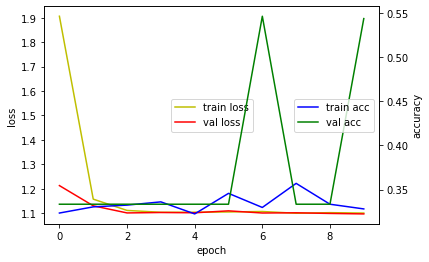

Test loss: 1.096675157546997
Test accuracy: 0.5440000295639038


In [9]:
hist_view(hist)
score = model.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
